In [1]:
from torchvision import models
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
# Apply the transformations needed
import torchvision.transforms as T

import sys
sys.path.append('..')
from opencv_course import ImageUtil

dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

In [2]:
net = dlab
path = './images/change/girl4.jpg'
img = Image.open(path)
if np.array(img).shape[2] == 4:
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGRA2BGR);
    img = Image.fromarray(img)

# Comment the Resize and CenterCrop for better inference results
trf = T.Compose([T.Resize(450), 
               #T.CenterCrop(224), 
               T.ToTensor(), 
               T.Normalize(mean = [0.485, 0.456, 0.406], 
                           std = [0.229, 0.224, 0.225])])
#GPU
#     inp = trf(img).unsqueeze(0).to(dev)
#     out = net.to(dev)(inp)['out']
#CPU
inp = trf(img).unsqueeze(0)
out = net(inp)['out']

om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

<Figure size 720x720 with 0 Axes>

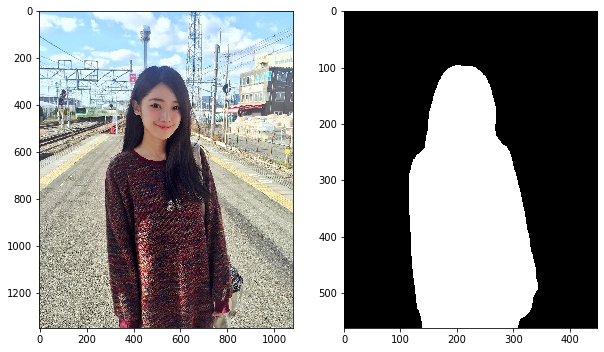

In [3]:
# Define the helper function
image = om
source = path
nc=21
#最好把要自动勾选的物体变成白色
label_colors = np.array([(0, 0, 0),  # 0=background
           # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
           (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
           # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
           (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
           # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
           (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (255, 255, 255),
           # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
           (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

r = np.zeros_like(image).astype(np.uint8)
g = np.zeros_like(image).astype(np.uint8)
b = np.zeros_like(image).astype(np.uint8)

for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]


rgb = np.stack([r, g, b], axis=2)

# Load the foreground input image 
foreground = cv2.imread(source)

ImageUtil.imshow([foreground, rgb], columns=2,figsize=(10,10))

<Figure size 1080x720 with 0 Axes>

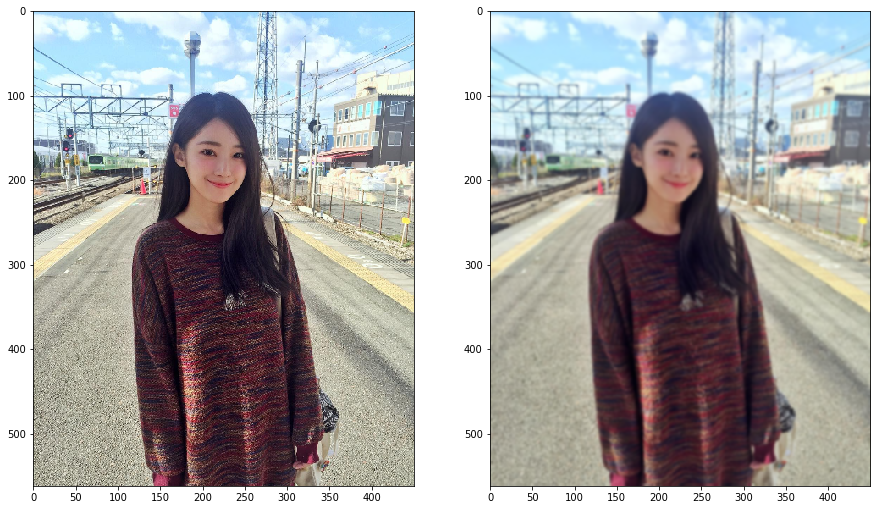

In [4]:
# Change the color of foreground image to RGB 
# and resize image to match shape of R-band in RGB output map  
foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))

# Create a Gaussian blur of kernel size 7 for the background image
blurredImage = cv2.GaussianBlur(foreground, (7,7), 0)

ImageUtil.imshow([foreground, blurredImage], columns=2, figsize=(15,10), cvtColor=None)

<Figure size 720x720 with 0 Axes>

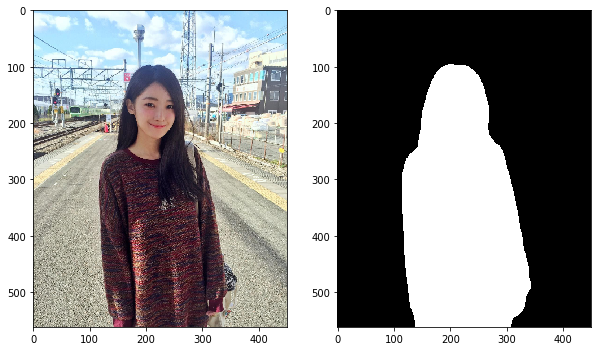

In [5]:
# Convert uint8 to float
foreground_float = foreground.astype(float)
blurredImage = blurredImage.astype(float)

# Create a binary mask of the RGB output map using the threshold value 0
th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

ImageUtil.imshow([foreground, alpha], columns=2, figsize=(10,10), cvtColor=None)

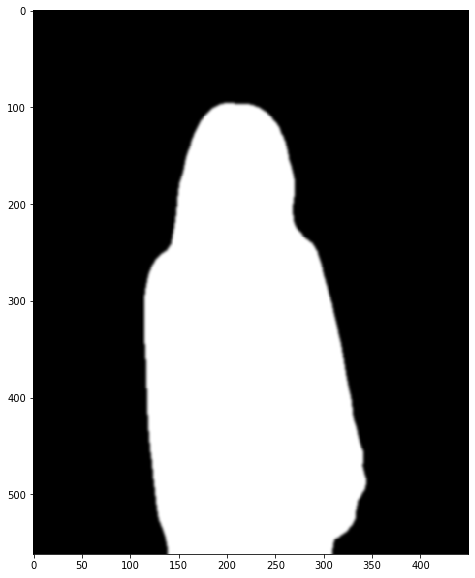

In [6]:
# Apply a slight blur to the mask to soften edges
alpha = cv2.GaussianBlur(alpha, (7,7),0)

ImageUtil.imshow([alpha], figsize=(10,10))

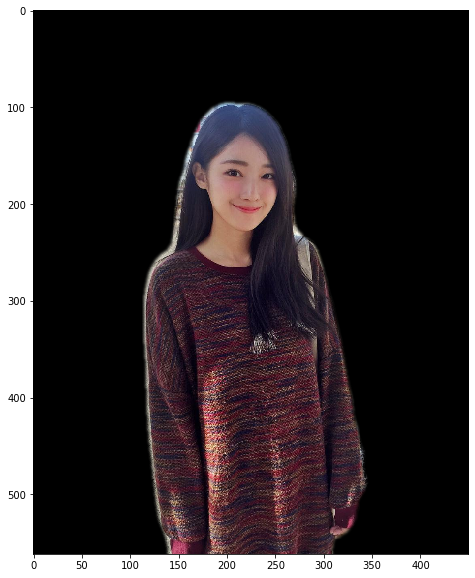

In [7]:
# Normalize the alpha mask to keep intensity between 0 and 1
alpha_float = alpha.astype(float)/255

# Multiply the foreground with the alpha matte
foreground_float = cv2.multiply(alpha_float, foreground_float)

ImageUtil.imshow([foreground_float.astype('uint8')], figsize=(10,10), cvtColor=None)

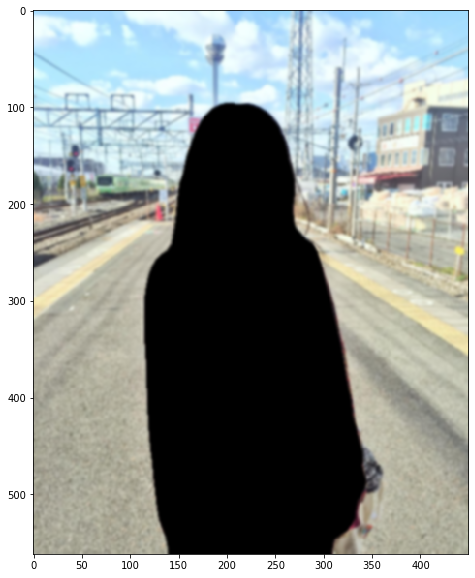

In [8]:
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha_float, blurredImage)  

ImageUtil.imshow([background.astype('uint8')], figsize=(10,10), cvtColor=None)

<Figure size 720x720 with 0 Axes>

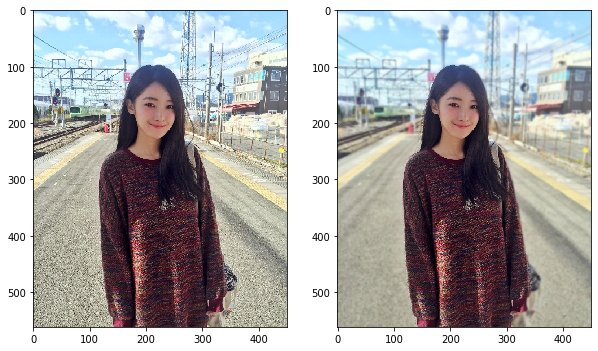

In [9]:
# Add the masked foreground and background
outImage = cv2.add(foreground_float, background)

ImageUtil.imshow([foreground, outImage.astype('uint8')], columns =2, figsize=(10,10), cvtColor=None)

<Figure size 1080x720 with 0 Axes>

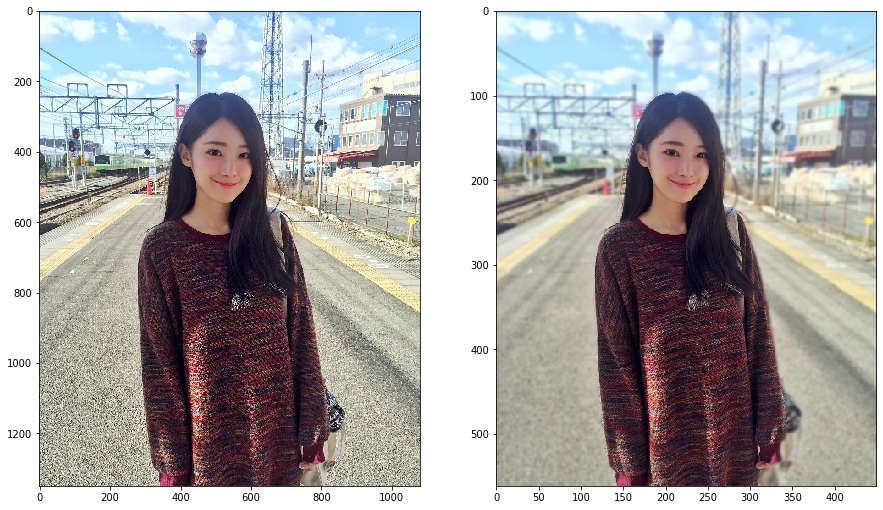

In [10]:
# Return a normalized output image for display
rgb = outImage/255

ImageUtil.imshow([np.array(img), np.array(rgb)], columns=2, rows=1, figsize=(15,10), cvtColor=None)